In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(3)

In [3]:
# Import data
classes = 100
tf = [transforms.Grayscale()]
train = datasets.get_cifar(classes, transform=tf)
test = datasets.get_cifar(classes, transform=tf, train=False)

# Get data parameters
N = len(train)
M = np.prod(train.size)

# Set training parameters and loader
batch_size = 32
epochs = 20
nu = 7.5e-5
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'ie_deblur_ls_resolvent'

In [4]:
# Generate Blur
blur = nn.Conv2d(1, 1, 3, 1, 1, bias=False, padding_mode='circular')
blur.weight.data[...] = 1/9
blur.weight.requires_grad = False;

# Generate GPU version
blur_gpu = nn.Conv2d(1, 1, 3, 1, 1, bias=False, padding_mode='circular')
blur_gpu.weight.data[...] = 1/9
blur_gpu.weight.requires_grad = False;
blur_gpu.to(device);

In [5]:
# Initialize dimensions, models, parameters and optimizers
dims_pie = [M] * 3
dims_ae = [M] * 3


model_kwargs = {
    'activation': modules.BiCELU,
    'activation_params': {},
    'device': device,
}

nets = {
    "IRE": models.dense.AdjointDense(dims_pie, diagonal=False, resolvent=True, lmbda=0.5, iter=16, **model_kwargs),
    "IRED": models.dense.AdjointDense(dims_pie, diagonal=True, resolvent=True, lmbda=0.5, iter=16, **model_kwargs),
}

for k, model in nets.items():
    loss_trace[k] = {}
    opts[k] = torch.optim.Adam(model.parameters(), lr = nu)

In [6]:
# Define objective function

def objective_function(x, xh, y=None, yh=None, params=None, l2_lambda=1e-6, alpha=4, reduction='mean'):
    losses = {}

    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    losses['lx'] = F.mse_loss(xh, x, reduction=reduction)
    if y is not None:
        losses['ly'] = F.mse_loss(yh, y, reduction=reduction)
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [7]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:5}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params IRE  :  2099200
No. params IRED :  2100224


In [8]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.tensor(train.data[sample_indices_small]).float().mean(-1) / 255
yims = blur(xims[:,None,...])
xs = xims.flatten(-2, -1).to(device)
ys = yims.flatten(-3, -1).to(device)
xt = torch.tensor(test.data).float().mean(-1).flatten(-2, -1).to(device) / 255
yt = blur((torch.tensor(test.data).float().permute(0,3,1,2).mean(1)[:,None,...] / 255)).flatten(-3, -1).to(device)

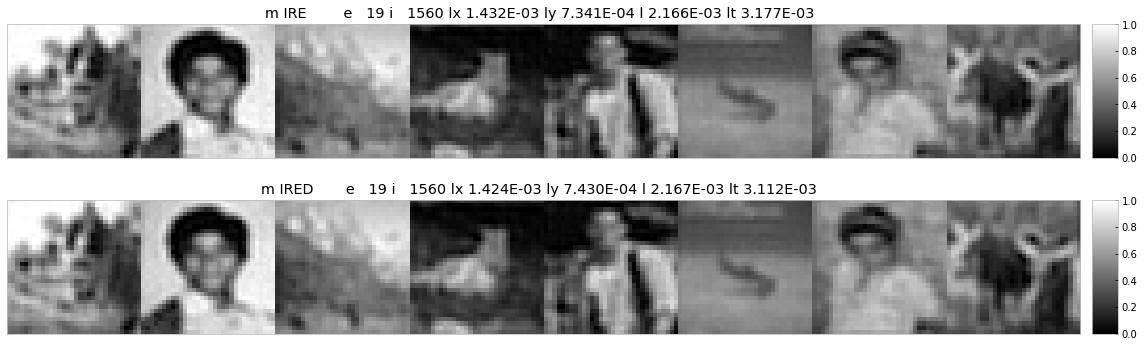

In [9]:
# Training loop

for e in range(epochs):
    i = 0
    for x, _ in loader:
        x = x.to(device)
        with torch.no_grad():
            y = blur_gpu(x).flatten(-3, -1)
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()
            xh = nets[cur].T(y)
            yh = nets[cur](x)            
            loss, ldicts[cur] = objective_function(x, xh, y, yh)

            loss.backward()
            opts[cur].step()
            
            # Validation
            with torch.no_grad():
                yth = nets[cur](xt)
                xth = nets[cur].T(yt)
                ldicts[cur]['lt'] = utils.loss.logcosh(xth, xt, alpha=4, reduction='mean')

            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v.item())


        # Plot and Report
        if i % 10 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    yhs = nets[cur](xs)
                    xhs[cur] = nets[cur].T(ys, iter=e+2)
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, cmap='gray', save=i % 50 == 0, path=experiment_name)
            
        i += 1

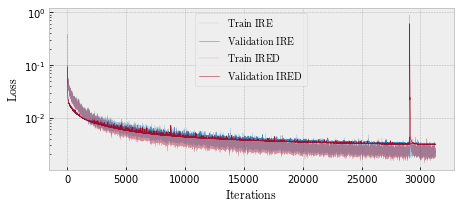

In [10]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    p = plt.plot(np_loss_trace[k]["l"], linewidth=.3, label=f"$\mathrm{{Train\,\,{k}}}$", alpha=0.4)
    plt.plot(np_loss_trace[k]["lt"], linewidth=.5, label=f"$\mathrm{{Validation\,\,{k}}}$", alpha=0.95, color=p[0].get_color())

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}.pdf')

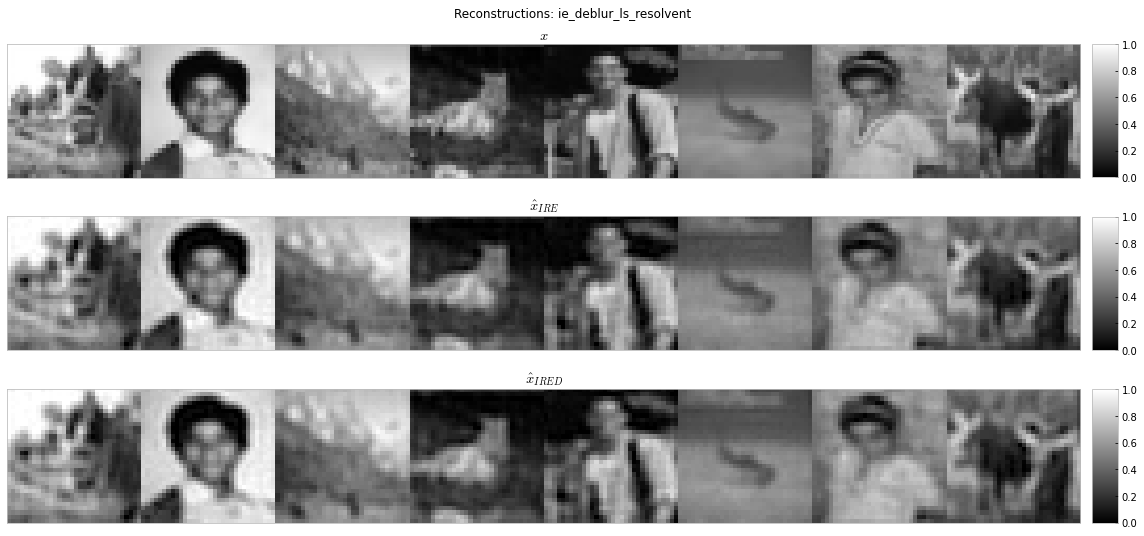

In [11]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Plot results
with torch.no_grad():
    xhs = {"": xims}
    
    for k in nets.keys():
        xhs[k] = nets[k].T(ys)
        xhs[k] = xhs[k].to('cpu').unflatten(-1, train.size)
    
utils.reporting.plot_results(xhs, f'Reconstructions: {experiment_name}', cmap='gray', fname=experiment_name)

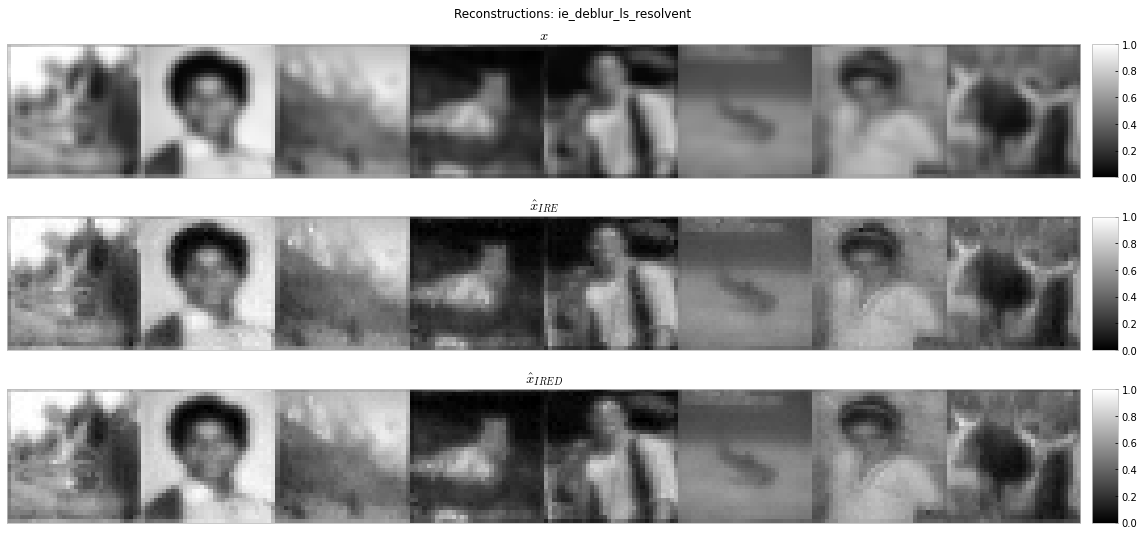

In [12]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Plot results
with torch.no_grad():
    xhs = {"": blur(xims[:,None,...])[:,0,...]}
    
    for k in nets.keys():
        xhs[k] = nets[k](xs)
        xhs[k] = xhs[k].to('cpu').unflatten(-1, train.size)
    
utils.reporting.plot_results(xhs, f'Reconstructions: {experiment_name}', cmap='gray', fname=experiment_name)

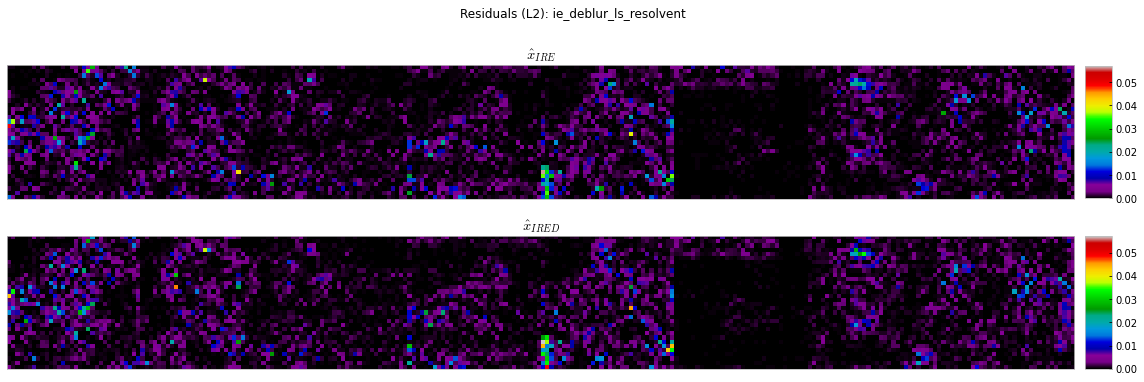

In [13]:
# Plot residuals (L2)
with torch.no_grad():
    xhs = {}
    curmax = 0

    for k in nets.keys():
        xhs[k] = nets[k].T(ys)
        xhs[k] = xhs[k].to('cpu').unflatten(-1, train.size)
        xhs[k] = (xhs[k] - xims)**2
        if torch.max(xhs[k]) > curmax:
            curmax = torch.max(xhs[k])

utils.reporting.plot_results(
    xhs, f'Residuals (L2): {experiment_name}', vmax=curmax, fname=experiment_name + 'res', root='../figures/results/'
)

In [14]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    
torch.cuda.empty_cache()

In [15]:
print(f"Relative Error:")
for k, model in nets.items():
    with torch.no_grad():
        XH = model.T(yt.cpu())
        YH = model(xt.cpu())
        re_x = utils.metrics.relative_error(XH, xt.cpu(), reduction='mean')
        re_y = utils.metrics.relative_error(YH, yt.cpu(), reduction='mean')
        mse_x = F.mse_loss(XH, xt.cpu(), reduction='mean')
        mse_y = F.mse_loss(YH, yt.cpu(), reduction='mean')
    print(
        f"{k:6}: " + 
        f"REx {re_x:4E} " +
        f"REy {re_y:4E} " +
        f"RE  {(re_x + re_y) / 2:4E} " +
        f"MSEx {mse_x:4E} " + 
        f"MSEy {mse_y:4E} " +
        f"MSE  {(mse_x + mse_y) / 2:4E} "
    )

Relative Error:
IRE   : REx 7.982207E-02 REy 5.385385E-02 RE  6.683796E-02 MSEx 1.627780E-03 MSEy 7.232131E-04 MSE  1.175497E-03 
IRED  : REx 7.848607E-02 REy 5.253396E-02 RE  6.551001E-02 MSEx 1.596291E-03 MSEy 6.877563E-04 MSE  1.142024E-03 


In [16]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    with torch.no_grad():
        XH = model.T(yt.cpu())
        YH = model(xt.cpu())
        psnr_x = utils.metrics.psnr(xt.cpu(), XH)
        ssim_x = utils.metrics.ssim(
            xt.cpu().unflatten(-1, (32, 32))[:,None,...], 
            XH.unflatten(-1, (32, 32))[:,None,...]
        )
        psnr_y = utils.metrics.psnr(yt.cpu(), YH)
        ssim_y = utils.metrics.ssim(
            yt.cpu().unflatten(-1, (32, 32))[:,None,...], 
            YH.unflatten(-1, (32, 32))[:,None,...]
        )
    print(
        f"{k:6}: " + 
        f"PSNRx: {psnr_x:4E} " +
        f"PSNRy: {psnr_y:4E} " +
        f"PSNR:  {(psnr_y + psnr_x) / 2:4E} " +
        f"SSIMx: {ssim_x:4E} " +
        f"SSIMy: {ssim_y:4E} " +
        f"SSIM:  {(ssim_y + ssim_x) / 2:4E} "
    )

Image Reconstruction Metrics:
IRE   : PSNRx: 2.788404E+01 PSNRy: 3.140734E+01 PSNR:  2.964569E+01 SSIMx: 9.349964E-01 SSIMy: 9.561480E-01 SSIM:  9.455722E-01 
IRED  : PSNRx: 2.796888E+01 PSNRy: 3.162565E+01 PSNR:  2.979727E+01 SSIMx: 9.378843E-01 SSIMy: 9.589077E-01 SSIM:  9.483960E-01 


In [17]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)
    cur = k

# Calculate estimated Jacobian from test data
# NOTE: This process can take some time
no_cond = 1000
_x = xt.clone()[:no_cond].to(device)
_x.requires_grad = True
Js = {}
for k, model in nets.items():
    Js[k] = torch.zeros(no_cond, M, M)
    for i in tqdm(range(no_cond)):
        model.zero_grad()
        Js[k][i] = torch.autograd.functional.jacobian(
            lambda x: model.T(model(x)),
            _x[i],
            vectorize=True
    ).cpu()

# Move models to CPU
for k in nets:
    nets[k] = nets[k].to('cpu')

# Move samples to CPU
_x = _x.to('cpu')
torch.cuda.empty_cache()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
print("Jacobian Relative Condition Numbers (L2 Norm):")
for k, J in Js.items():
    _xh = nets[k](_x)
    rel = torch.mean(torch.linalg.norm(_xh, dim=1) / torch.linalg.norm(_x, dim=1))
    Jnorm = torch.mean(torch.linalg.norm(J, dim=(1,2)))
    relnorm = torch.mean(
        torch.linalg.norm(J, dim=(1,2)) / (torch.linalg.norm(_xh, dim=1) / torch.linalg.norm(_x, dim=1))
    )
    print(f"{k:8} den: {rel:.6E} abs_cond: {Jnorm:.6E} rel_cond: {relnorm:.6E}") 

Jacobian Relative Condition Numbers (L2 Norm):
IRE      den: 9.797186E-01 abs_cond: 3.044624E+01 rel_cond: 3.108157E+01
IRED     den: 9.812045E-01 abs_cond: 3.185876E+01 rel_cond: 3.247277E+01


In [19]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(M).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [20]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.mse_loss(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

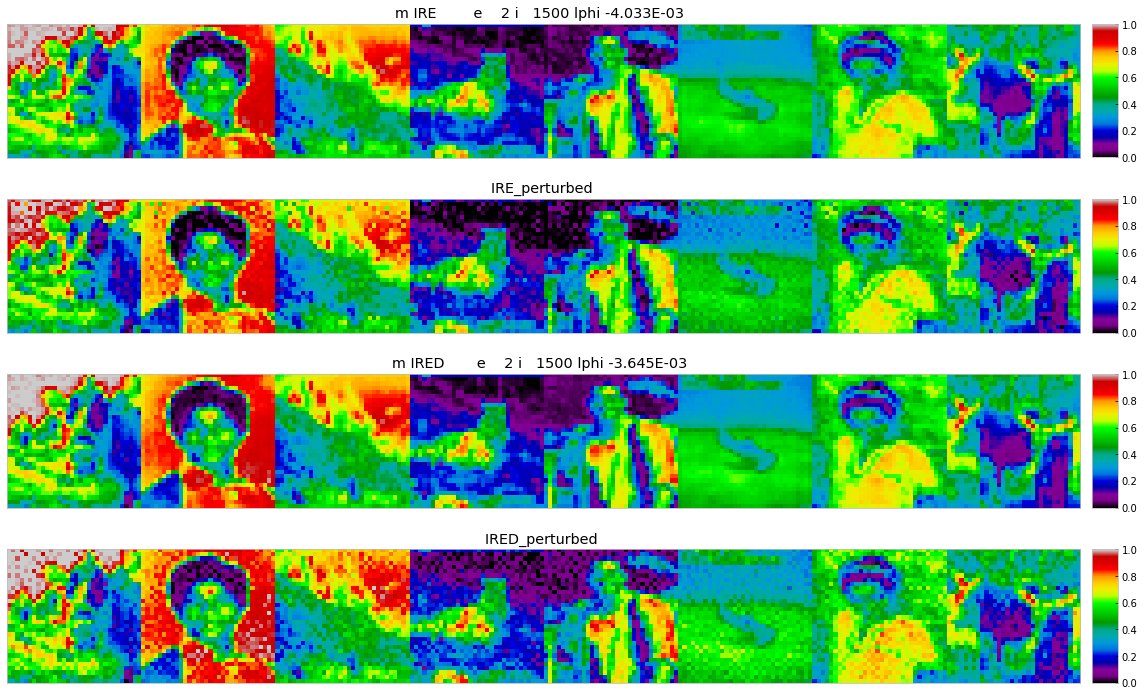

In [21]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur], 1, 2)

            xh = nets[cur](x)
            xe = nets[cur](x + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 500 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)

                    xhs[cur] = nets[cur].T(nets[cur](xs))
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
                    xhs[per] = nets[cur].T(nets[cur](xs + r))
                    xhs[per] = xhs[per].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False)            
        i += 1

In [22]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

# Calculate relative error
print(f"Relative Error:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    XE = model.T(model(xt.cpu() + r))
    print(f"{k:6}: {utils.metrics.relative_error(xt.cpu() + rs[k].cpu(), XE, reduction='mean')}")


print(f"Relative Cond:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    XE = model.T(model(xt.cpu() + r))
    XH = model.T(model(xt.cpu()))

    rerr_psi = utils.metrics.relative_error(XH, XE, reduction='mean')
    rerr_x = utils.metrics.relative_error(xt.cpu(), xt.cpu() + r, reduction='mean')
    cond_no = utils.metrics.relative_cond_no(XH, XE, xt.cpu(), r, reduction='mean')
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Error:
IRE   : 0.9150878190994263
IRED  : 0.6608554124832153
Relative Cond:
IRE   : 0.070782 0.065052 3.820338
IRED  : 0.064905 0.065052 3.503137


In [23]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [24]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)

In [25]:
# Load models

serialized_path = f'../serialized/experiments/{experiment_name}/'
for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'rb') as outfile:
        nets[name] = torch.load(outfile)

In [26]:
I = torch.eye(1024)

lmbda = nets['IRE'].net.U.affine.W.lmbda

_V = nets['IRE'].net.V.affine.W.weight.detach()
_Vinv = nets['IRE'].net.V.affine.W._liouville_neumann(12).detach()
_U = nets['IRE'].net.U.affine.W.weight.detach()
_Uinv = nets['IRE'].net.U.affine.W._liouville_neumann(12).detach()

for k, w in {'V':(I - lmbda*_V), 'Vinv':_Vinv, 'U': (I - lmbda*_U), 'Uinv':_Uinv}.items():
    s = torch.linalg.svdvals(w)
    print(f'{k:6}', s[0].item(), s[-1].item())

V      4.332925796508789 0.18744921684265137
Vinv   4.321156978607178 0.2774055302143097
U      2.294161081314087 0.07069318741559982
Uinv   11.61535358428955 0.44168204069137573


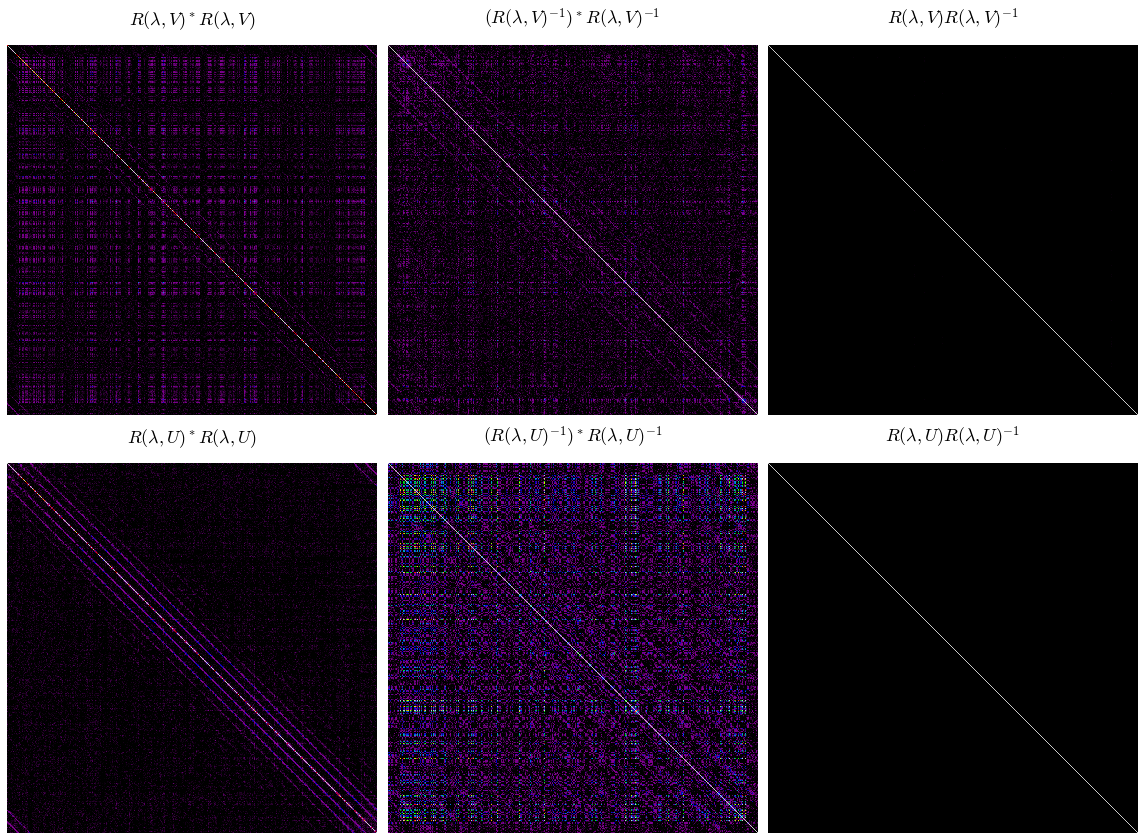

In [27]:
I = torch.eye(1024)
fig, ax = plt.subplots(2, 3, figsize=(16, 12))
lmbda = nets['IRE'].net.U.affine.W.lmbda

ax[0,0].matshow((I - lmbda*_V).T @ (I - lmbda*_V), vmin=0, vmax=1)
ax[0,0].set_title(r'$R(\lambda, V)^* R(\lambda, V)$', fontsize=18)
ax[0,1].matshow((_Vinv.T) @ (_Vinv), vmin=0, vmax=1)
ax[0,1].set_title(r'$(R(\lambda, V)^{-1})^* R(\lambda, V)^{-1}$', fontsize=18)
ax[0,2].matshow((I - lmbda*_V) @ (_Vinv), vmin=0, vmax=1)
ax[0,2].set_title(r'$R(\lambda, V) R(\lambda, V)^{-1}$', fontsize=18)

ax[1,0].matshow((I - lmbda*_U).T @ (I - lmbda*_U), vmin=0, vmax=1)
ax[1,0].set_title(r'$R(\lambda, U)^* R(\lambda, U)$', fontsize=18)
ax[1,1].matshow((_Uinv.T) @ (_Uinv), vmin=0, vmax=1)
ax[1,1].set_title(r'$(R(\lambda, U)^{-1})^* R(\lambda, U)^{-1}$', fontsize=18)
ax[1,2].matshow((I - lmbda*_U) @ (_Uinv), vmin=0, vmax=1)
ax[1,2].set_title(r'$R(\lambda, U) R(\lambda, U)^{-1}$', fontsize=18)

for a in ax:
    for _a in a:
        _a.grid(False)
        _a.axis('off')

plt.savefig('../figures/misc/ie_resolvent_orhto.pdf')

In [28]:
_V = nets['IRED'].net.V.affine.W.weight.detach()
_Vinv = nets['IRED'].net.V.affine.W._liouville_neumann(12).detach()
_U = nets['IRED'].net.U.affine.W.weight.detach()
_Uinv = nets['IRED'].net.U.affine.W._liouville_neumann(12).detach()

for k, w in {'V':(I - lmbda*_V), 'Vinv':_Vinv, 'U': (I - lmbda*_U), 'Uinv':_Uinv}.items():
    s = torch.linalg.svdvals(w)
    print(f'{k:6}', s[0].item(), s[-1].item())

V      3.97334885597229 0.22121980786323547
Vinv   4.473283290863037 0.25564396381378174
U      2.440742015838623 0.12363959848880768
Uinv   7.88409948348999 0.40915292501449585


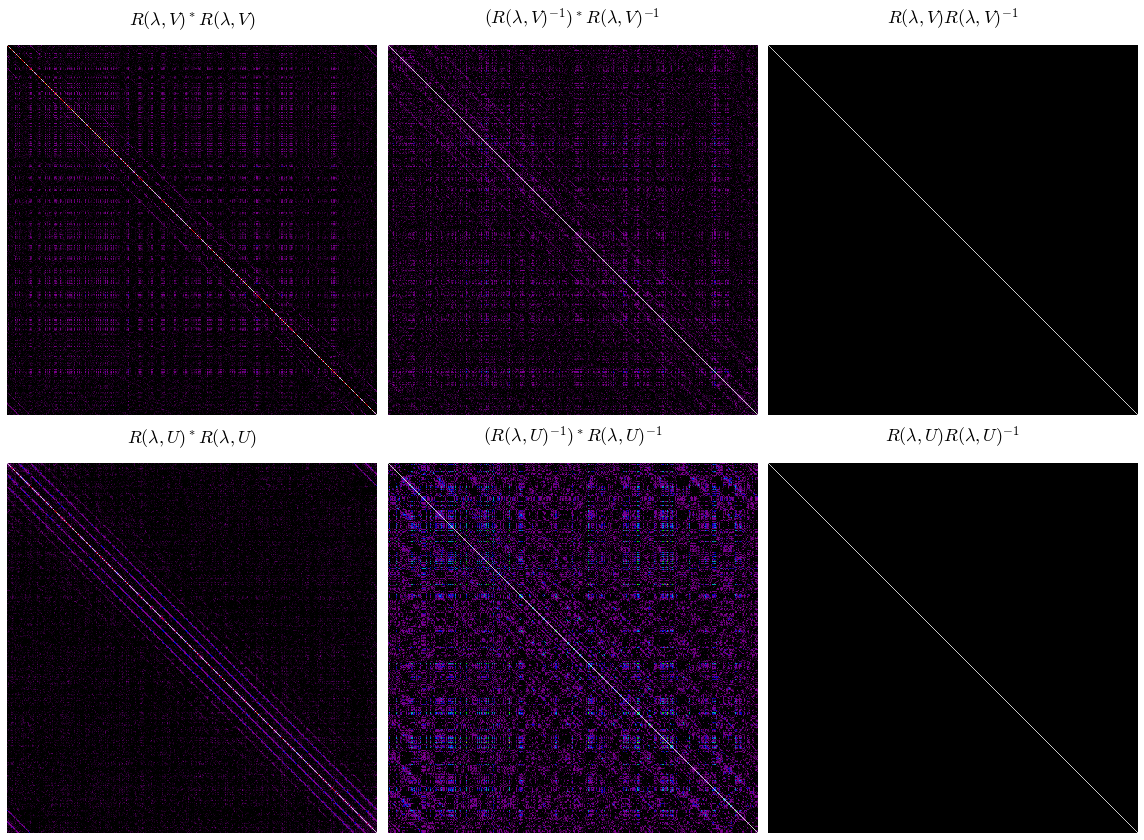

In [29]:
I = torch.eye(1024)
fig, ax = plt.subplots(2, 3, figsize=(16, 12))

ax[0,0].matshow((I - lmbda*_V).T @ (I - lmbda*_V), vmin=0, vmax=1)
ax[0,0].set_title(r'$R(\lambda, V)^* R(\lambda, V)$', fontsize=18)
ax[0,1].matshow((_Vinv.T) @ (_Vinv), vmin=0, vmax=1)
ax[0,1].set_title(r'$(R(\lambda, V)^{-1})^* R(\lambda, V)^{-1}$', fontsize=18)
ax[0,2].matshow((I - lmbda*_V) @ (_Vinv), vmin=0, vmax=1)
ax[0,2].set_title(r'$R(\lambda, V) R(\lambda, V)^{-1}$', fontsize=18)

ax[1,0].matshow((I - lmbda*_U).T @ (I - lmbda*_U), vmin=0, vmax=1)
ax[1,0].set_title(r'$R(\lambda, U)^* R(\lambda, U)$', fontsize=18)
ax[1,1].matshow((_Uinv.T) @ (_Uinv), vmin=0, vmax=1)
ax[1,1].set_title(r'$(R(\lambda, U)^{-1})^* R(\lambda, U)^{-1}$', fontsize=18)
ax[1,2].matshow((I - lmbda*_U) @ (_Uinv), vmin=0, vmax=1)
ax[1,2].set_title(r'$R(\lambda, U) R(\lambda, U)^{-1}$', fontsize=18)

for a in ax:
    for _a in a:
        _a.grid(False)
        _a.axis('off')

plt.savefig('../figures/misc/ie_resolvent_orhto_diag.pdf')

In [30]:
M = 1024
random_matrix_results = []

for i in tqdm(range(10000)):
    with torch.no_grad():
        _lin = nn.Linear(M, M)
        A = _lin.weight.detach()
        SA = A.T @ A
        relerr = utils.metrics.relative_error_matrix(torch.eye(M), SA, 'fro')
        result = {'relative_error': relerr} #'A': A, 'SA': SA, 
        random_matrix_results.append(result)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [31]:
relative_errors = [e['relative_error'].item() for e in random_matrix_results]

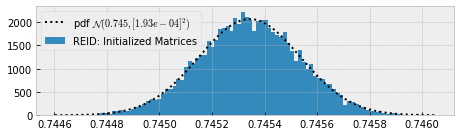

In [32]:
re_mu = np.mean(relative_errors)
re_sd = np.std(relative_errors, ddof=1)

re_range = np.linspace(min(relative_errors), max(relative_errors), 2000)
re_pdf = stats.norm.pdf(re_range, loc=re_mu, scale=re_sd)

fig, ax = plt.subplots(figsize=(6.5,2))

ax.plot(re_range, re_pdf, ':', color='k', label=f'pdf $\mathcal{{N}}({re_mu:.3f}, [{re_sd:.2e}]^2)$')
ax.hist(relative_errors, bins=100, density=True, label='REID: Initialized Matrices');

plt.legend();
plt.savefig(f'../figures/other/{experiment_name}_randmatrix_histogram.pdf')

In [33]:
_VV = nets['IRE'].net.V.affine.W.weight.detach()
_VVinv = nets['IRE'].net.V.affine.W._liouville_neumann(12).detach()
_UU = nets['IRE'].net.U.affine.W.weight.detach()
_UUinv = nets['IRE'].net.U.affine.W._liouville_neumann(12).detach()

In [34]:
gramians = {
    'IRE': {
        r'$R(\lambda,V)$' : (I - lmbda*_VV).T @ (I - lmbda*_VV),
        r'$R(\lambda,U)$' : (I - lmbda*_UU).T @ (I - lmbda*_UU),
    },
    'IRED': {
        r'$R(\lambda,V)$' : (I - lmbda*_V).T @ (I - lmbda*_V),
        r'$R(\lambda,U)$' : (I - lmbda*_U).T @ (I - lmbda*_U),
    },    
}


In [35]:
# Compute likelihood of relative error observed in weights
print("Likelihood of Observing Relative Error w.r.t. Identity:")
weights_relerr = []
for k, dct in gramians.items():
    for j, sa in dct.items():
        relerr = utils.metrics.relative_error_matrix(torch.eye(M), sa, 'fro').double().item()
        weights_relerr.append(relerr)
        print(f"{k:6} - {j:24} : {stats.norm.pdf(relerr, loc=re_mu, scale=re_sd):.12E}")

Likelihood of Observing Relative Error w.r.t. Identity:
IRE    - $R(\lambda,V)$           : 0.000000000000E+00
IRE    - $R(\lambda,U)$           : 0.000000000000E+00
IRED   - $R(\lambda,V)$           : 0.000000000000E+00
IRED   - $R(\lambda,U)$           : 0.000000000000E+00


In [36]:
# Compute z-scores of results
print("Z-scores of Relative Error Observations:")
i = 0
for k, dct in gramians.items():
    for j, sa in dct.items():
        totals_relerr = relative_errors + [weights_relerr[i]]
        z_scores = stats.zscore(totals_relerr)
        relevant_zs = z_scores[-1]
        print(f"{k:6} - {j:24}: {relevant_zs}")
        i += 1

Z-scores of Relative Error Observations:
IRE    - $R(\lambda,V)$          : -94.12299057452844
IRE    - $R(\lambda,U)$          : -98.63781630323504
IRED   - $R(\lambda,V)$          : -98.92711898368998
IRED   - $R(\lambda,U)$          : -97.78539389176441


In [37]:
weights_relerr

[0.6915682554244995,
 0.6296265721321106,
 0.6146678328514099,
 0.6551799178123474]

In [38]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)
# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(M).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [39]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.mse_loss(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

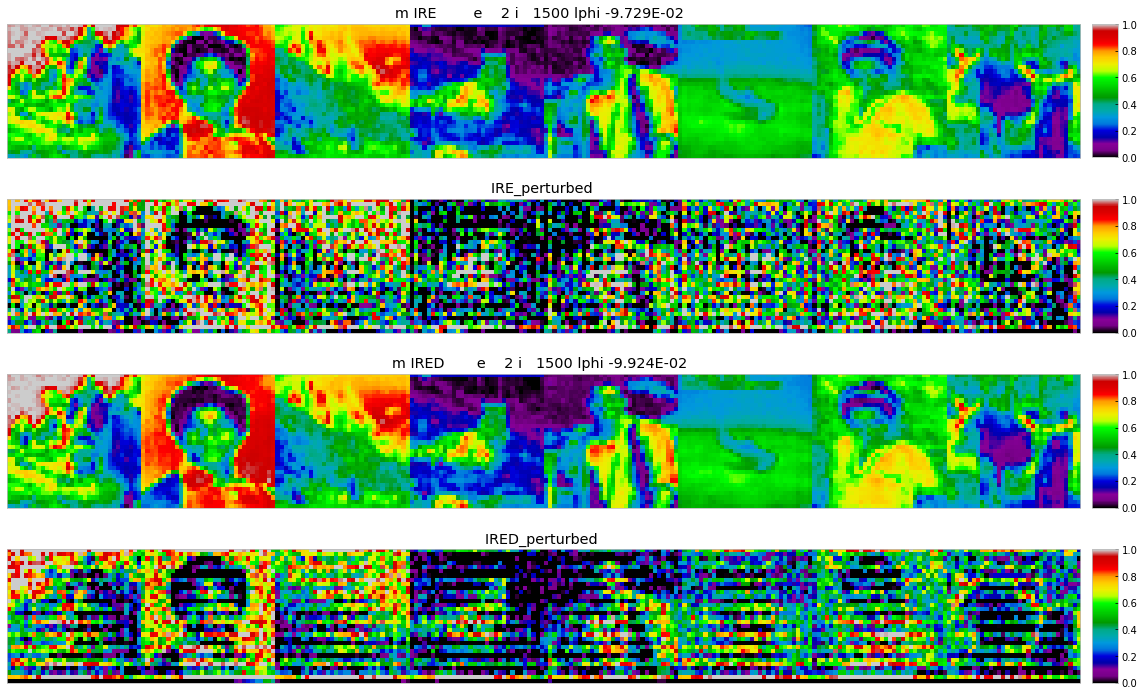

In [40]:
# Training loop

for e in range(epochs):
    i = 0
    for x, y in loader:
        with torch.no_grad():
            y = blur_gpu(x.to(device)).flatten(-3, -1)
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur], 1, 2)

            xh = nets[cur].T(y)
            xe = nets[cur].T(y + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 500 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur], 1, 2)

                    xhs[cur] = nets[cur].T(nets[cur](xs))
                    xhs[cur] = xhs[cur].to('cpu').unflatten(-1, train.size)
                    xhs[per] = nets[cur].T(nets[cur](xs) + r)
                    xhs[per] = xhs[per].to('cpu').unflatten(-1, train.size)
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False)            
        i += 1

In [41]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    YE = model.T(yt.cpu() + r)
    YH = model.T(yt.cpu())

    cond_no = utils.metrics.relative_cond_no(YH, YE, yt.cpu(), r, reduction='mean')
    
    print(f"{k:6}: {cond_no.item():2.6f}")

Relative Cond:
IRE   : 34.912830
IRED  : 35.097031
